### Skeleton for HW7
Rename this file and place your code here.

**Note: If a cell begins with HW: do not change it and leave the markdown there so I can expect a basic level of  organization that is common to all HW. This also clearly delineates the sections for me.**

#### HW: For the preamble, leave any general comments here and load all needed modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.special import jv # Bessel function of the first kind of real order and complex argument
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve
import seaborn as sns
import pandas as pd

### Part I: Complex optimization and root finding

**HW 7-1**: Use any scipy function or functions to find the global maximum (and its location) of  

$f(x,y,z)=−10e^{-\frac{x^2+y^2+z^2}{100}}J_2(x+3y+2z-\sqrt{10})\cos(\pi xy−\sqrt{2}xz)$

Where $J_2(x)$ is the Bessel function of the first kind of order 2.

In [2]:
def func(x):
    ''' Function defined in the HW7 problem 7-1 problem statement. 

    inputs: 
        x: 3-dimensional array (x, y,z)

    returns: the function
    '''
    
    # x[0] = x
    # x[1] = y
    # x[2] = z
    
    return -10*np.exp(-(x[0]**2+x[1]**2+x[2]**2)/100)*jv(2,x[0]+3*x[1]+2*x[2]-np.sqrt(1))*np.cos(np.pi*x[0]*x[1]-np.sqrt(2)*x[0]*x[2])

def negfunc(x):
    ''' Negative of the function defined in the HW7 problem 7-1 problem statement. 

    inputs: 
        x: 3-dimensional array (x, y,z)

    returns: the function
    '''

    # x[0] = x
    # x[1] = y
    # x[2] = z
    
    return -func(x)

# just to test the fucnctions, these two should be equal in magnitude and opposite in sign
# print(func([1, 2, 3]))
# print(negfunc([1, 2, 3]))

# originally tried optimize.brute for the range -2 to 2 for x, y, and z to get a good initial guess for optimize.basinhopping
# was further refined based on optimize.basinhopping results
results_brute = optimize.brute(negfunc,ranges=[[-1,0],[-1,0],[0,0.6]])

# working with optimize.basinhopping
# initial guess was refined based on outputs from original guess and from optimize.brute() result
results_basinhopping = optimize.basinhopping(negfunc, [-0.97, -0.76, 0.596], niter=100, T=1.0, stepsize=1.0)

globalMax = func([results_basinhopping.x[0],results_basinhopping.x[1],results_basinhopping.x[2]])

In [3]:
print(f'The global maximum is located at x = {results_basinhopping.x[0]:.3f}, y = {results_basinhopping.x[1]:.3f}, z = {results_basinhopping.x[2]:.3f} and is {globalMax:.3f}.')

The global maximum is located at x = -0.970, y = -0.760, z = 0.596 and is 4.775.


**HW 7-2**: As presented in class, ballistic motion in 2D is described by the system of second order differential equations
\begin{eqnarray*}
x^{\prime\prime} &=& 0 \\
y^{\prime\prime} &=& −g 
\end{eqnarray*}

Let's solve this system of equations with initial conditions $x(0) = 0$, $y(0) = 0$, and a boundary value at t = 5 seconds, with boundary condutions $x(5) = 10$ m, $y(5) = 20$ m. We're on earth, so $g = 9.8$ m s$^{−2}$

We'll use a "shooting" approach.  To do this, we note that this set of 2nd order equations is equal to the 4D initial value problem:

\begin{eqnarray}
x^{\prime} &=& v_x \\
v_x^{\prime} &=& 0 \\
y^{\prime} &=& v_y \\
v_y^{\prime}  &=& -g
\end{eqnarray}

In the shooting approach, you start out with some initial set of velocities, integrate them forward, and see how far you are off from satisfying the boundary conditions, and keep trying until you satisfy them.  This can be seen as a roots problem, which we can implement using `fsolve`.

We first implement a function that gives the derivatives as a function of time and location.

In [4]:
def ballistic(t,x):   
    '''
    Implementing the equations of a ballistic motion from above. 
    Note that although it doesn't explicitly depend on time, we need to include the 
    time dependence in the function to be in the form that solve_ivp can solve it.
    ''' 
    g = 9.81
    v = np.zeros(4)
    v[0] = x[1]   # dx/dt = v_x
    v[1] = 0      # dv_x/dt = 0 (no horizontal acceleration) 
    v[2] = x[3]   # dy/dt = v_y
    v[3] = -g     # dv_y/dt = -g (vertical acceleration from gravity)
    return v

We now write a function that solves the initial value problem of ballistic motion starting from an initial position with a given initial velocity, and returns the distance from a desired final point. 

In [5]:
def tozero(vinit,f,trange,xinit,xtarget):
    '''

    This function takes some function of derivatives, 
    integrates it from initial to final values given initial
    variables, and then looks to see how different it is from the guess.
    
    inputs: 
        vinit: is the initial velocity: 2d vector
            It has to be first because we are passing to fsolve.
        f: function to be integrated 
        t: range of times [tnitial and tfinal]
        xinit: initial variables [xinit (4D)]
        xtarget: target variables [2D]
        
    returns: the difference bewteen our real solution and the guessed solution.
    '''    
    # we start with solving the ivp with the specified trange and initial values
    results = solve_ivp(f,trange,[xinit[0],vinit[0],xinit[1],vinit[1]]) 
    finalx = results['y'][0,-1]  # extract the final x value
    finaly = results['y'][2,-1]  # extract the final y value
    # below: the difference in the final positions from the shooting guess,
    # and the desired value.  2D. 
    difference = [finalx-xtarget[0],finaly-xtarget[1]]
    return difference

In [6]:
# define our boundary conditions.
tfinal = 5
xinit = [0,0]
xtarget = [10,20]

In [7]:
#use fsolve solve to find the intial values of x and y velocity
#that satisfy the final conditions
truev = fsolve(tozero,x0=[10,10],args=(ballistic,[0,tfinal],xinit,xtarget))

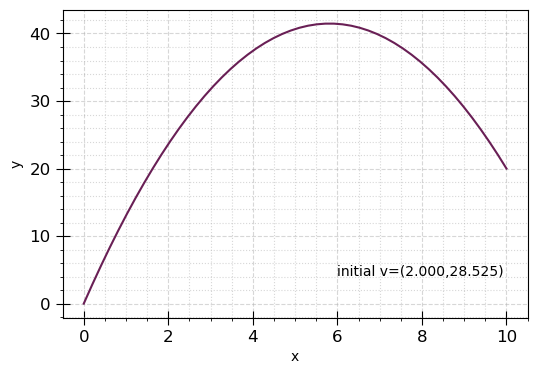

In [8]:
colors=sns.color_palette("rocket",10)

#plot the resulting solution
results = solve_ivp(ballistic,[0,tfinal],[0,truev[0],0,truev[1]],dense_output=True);
tall = np.linspace(0,tfinal) # plot at these values
xtraj = results['sol'](tall)[0]
ytraj = results['sol'](tall)[2]

fig, ax  = plt.subplots(figsize=(6,4))

ax.plot(xtraj, ytraj, color=colors[2])   #plot using the solution generated.
ax.set_xlabel('x')  
ax.set_ylabel('y')
wherex = 0.6*(np.max(xtraj)-np.min(xtraj))
wherey = 0.1*(np.max(ytraj)-np.min(ytraj))
ax.text(wherex,wherey,f'initial v=({truev[0]:.3f},{truev[1]:.3f})')
ax.grid(True, linestyle='--', alpha=0.5)  
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', alpha=0.5)
plt.tick_params(direction='inout', length=10, labelsize=12)
plt.show()

a)  If we add friction, the velocity equations are the same, but the acceleration equations become:
\begin{eqnarray*}
v_x^{\prime} &=& - k v_x \sqrt{v_x^2 + v_y^2}\\
v_y^{\prime}  &=& - g - k v_y \sqrt{v_x^2 + v_y^2}
\end{eqnarray*}
where $k$ is a constant that depends on the shape and mass of the projectile and the properties of the air it is travelling through.

Modify code to solve this problem if we include friction with $k=0.04$, our final values are still $x(t) = 10$ m, and $y(t) = 20$ m, and our elapsed time is $t = 8$ seconds.

In [9]:
def ballistic(t,x):   
    '''
    Implementing the equations of a ballistic motion from above, but accounting for friction in the acceleration equations. 
    Note that although it doesn't explicitly depend on time, we need to include the 
    time dependence in the function to be in the form that solve_ivp can solve it.
    ''' 
    g = 9.81
    k = 0.04
    v = np.zeros(4)

    v[0] = x[1]                                # dx/dt = v_x
    v[1] = -k*x[1]*np.sqrt(x[1]**2+x[3]**2)    # dv_x/dt = expression given above (accounts for friction)
    v[2] = x[3]                                # dy/dt = v_y
    v[3] = -g-k*x[3]*np.sqrt(x[1]**2+x[3]**2)  # dv_y/dt = -g (vertical acceleration from gravity)
    
    return v

In [10]:
def tozero(vinit,f,trange,xinit,xtarget):
    '''

    This function takes some function of derivatives, 
    integrates it from initial to final values given initial
    variables, and then looks to see how different it is from the guess.
    
    inputs: 
        vinit: is the initial velocity: 2d vector
            It has to be first because we are passing to fsolve.
        f: function to be integrated 
        t: range of times [tnitial and tfinal]
        xinit: initial variables [xinit (4D)]
        xtarget: target variables [2D]
        
    returns: the difference bewteen our real solution and the guessed solution.
    '''    
    # we start with solving the ivp with the specified trange and initial values
    results = solve_ivp(f,trange,[xinit[0],vinit[0],xinit[1],vinit[1]]) 
    finalx = results['y'][0,-1]  # extract the final x value
    finaly = results['y'][2,-1]  # extract the final y value
    # below: the difference in the final positions from the shooting guess,
    # and the desired value.  2D. 
    difference = [finalx-xtarget[0],finaly-xtarget[1]]
    return difference

In [11]:
# define our boundary conditions.
tfinal = 8        # s
xinit = [0,0]     # m
xtarget = [10,20] # m

In [12]:
#use fsolve solve to find the intial values of x and y velocity
#that satisfy the final conditions
truev = fsolve(tozero,x0=[10,10],args=(ballistic,[0,tfinal],xinit,xtarget))

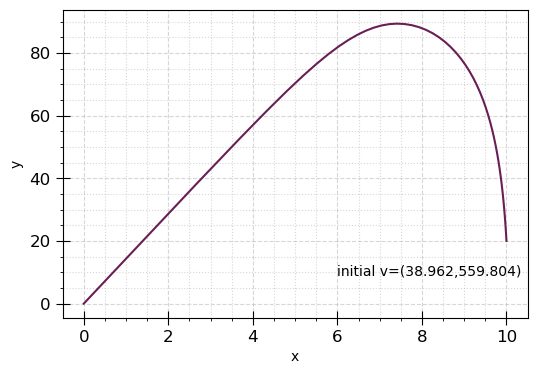

In [13]:
#plot the resulting solution
results = solve_ivp(ballistic,[0,tfinal],[0,truev[0],0,truev[1]],dense_output=True);
tall = np.linspace(0,tfinal) # plot at these values.
xtraj = results['sol'](tall)[0]
ytraj = results['sol'](tall)[2]

fig, ax  = plt.subplots(figsize=(6,4))
ax.plot(xtraj, ytraj, color=colors[2])   #plot using the solution generated.
ax.set_xlabel('x')  
ax.set_ylabel('y')
wherex = 0.6*(np.max(xtraj)-np.min(xtraj))
wherey = 0.1*(np.max(ytraj)-np.min(ytraj))
ax.text(wherex,wherey,f'initial v=({truev[0]:.3f},{truev[1]:.3f})')
ax.grid(True, linestyle='--', alpha=0.5)  
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', alpha=0.5)
plt.tick_params(direction='inout', length=10, labelsize=12)
plt.show()

b) Modify the code to solve the problem of ballistic motion with friction in 3 dimensions, and solve for the initial 3D velocity with $x(t=8s)=10$m, $y(t=8s)=20$m, and $z(t=8s)=30$m.  As is typical, assume gravity is now in the $z$ direction.  


In [14]:
def ballistic(t,x):   
    '''
    Implementing the equations of a ballistic motion from above, accounting for friction in the acceleration equations.
    Additionally, solves the problem in 3 dimensions with gravity in the z-direction.
    
    Note that although it doesn't explicitly depend on time, we need to include the 
    time dependence in the function to be in the form that solve_ivp can solve it.
    ''' 
    g = 9.81
    k = 0.04
    v = np.zeros(6)

    v[0] = x[1]                                        # dx/dt = v_x
    v[1] = -k*x[1]*np.sqrt(x[1]**2+x[3]**2+x[5]**2)    # dv_x/dt = expression given above (accounts for friction)
    v[2] = x[3]                                        # dy/dt = v_y
    v[3] = -k*x[3]*np.sqrt(x[1]**2+x[3]**2+x[5]**2)    # dv_y/dt = expression given above (accounts for friction)
    v[4] = x[5]                                        # dz/dt = v_z
    v[5] = -g-k*x[5]*np.sqrt(x[1]**2+x[3]**2+x[5]**2)  # dv_z/dt = includes gravity, expression given above (accounts for friction)
    
    return v

In [15]:
def tozero(vinit,f,trange,xinit,xtarget):
    '''

    This function takes some function of derivatives, 
    integrates it from initial to final values given initial
    variables, and then looks to see how different it is from the guess.
    
    inputs: 
        vinit: is the initial velocity: 2d vector
            It has to be first because we are passing to fsolve.
        f: function to be integrated 
        t: range of times [tnitial and tfinal]
        xinit: initial variables [xinit (4D)]
        xtarget: target variables [2D]
        
    returns: the difference bewteen our real solution and the guessed solution.
    '''    
    # we start with solving the ivp with the specified trange and initial values
    results = solve_ivp(f,trange,[xinit[0],vinit[0],xinit[1],vinit[1],xinit[2],vinit[2]]) 
    finalx = results['y'][0,-1]  # extract the final x value
    finaly = results['y'][2,-1]  # extract the final y value
    finalz = results['y'][4,-1]  # extract the final z value
    # below: the difference in the final positions from the shooting guess,
    # and the desired value.  2D. 
    difference = [finalx-xtarget[0],finaly-xtarget[1],finalz-xtarget[2]]
    return difference

In [16]:
# define our boundary conditions.
tfinal = 8            # s
xinit = [0,0,0]       # m
xtarget = [10,20,30]  # m

In [17]:
#solve for the answer.
truev = fsolve(tozero,x0=[10,10,10],args=(ballistic,[0,tfinal],xinit,xtarget))

In [18]:
#plot the resulting solution
results = solve_ivp(ballistic,[0,tfinal],[xinit[0],truev[0],xinit[0],truev[1],xinit[0],truev[2]],dense_output=True);
tall = np.linspace(0,tfinal) # plot at these values.
xtraj = results['sol'](tall)[0]
ytraj = results['sol'](tall)[2]
ztraj = results['sol'](tall)[4]

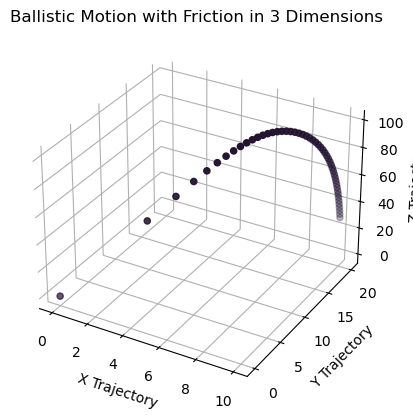

In [19]:
# used ChatGPT for the basic outline to generate this 3D scatter plot

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('X Trajectory')
ax.set_ylabel('Y Trajectory')
ax.set_zlabel('Z Trajectory')
ax.set_title('Ballistic Motion with Friction in 3 Dimensions')

ax.scatter(xtraj, ytraj, ztraj, color=colors[0], marker='o')  # 'c' specifies the color, 'marker' specifies the marker style

# change pane background to be white, ChatGPT was used to assemble this code but gave an outdated function so I updated it based on my newer version of Matplotlib
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))  # X-axis background color
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))  # Y-axis background color
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))  # Z-axis background color

plt.show()

### Part II: Using `pandas` for data analysis

**HW 7-3**: Load the Harvard Clean Energy Project Database (`HCEPDB_moldata.csv`) into a pandas data frame.  

1. Use both `cut` and Boolean logic to divide the data set into multiple sets, and print statistics for each of the groups.
1. Use `groupby` and perform three types of operations on the split data; aggreggation, transformation, and filtration (see https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html). Any type of these operations is fine.
1. Explore the data set and identify any interesting correlations or covariances beteen the variables in the data set, or seperate out interesting sets of molecules according to some criteria. You don't have to discover something new, but try to justify your explorations with comments in Markdown in the notebook. I expect a minimum of three operations and/or transformations, and the use of several functions that you looked up from the `pandas` documentation that we didn't do in class. Document what you find. For reference: 
   * PCE = Photon Conversion Efficiency
   * E_HOMO = Energy of the highest occupied energy level
   * E_LUMO = Energy of the lowest occupied energy level
   * VOC = Open circut voltage
   * JSC = Short circut current 

This is not intended to be super in-depth, just to gain experience with the basic operations of pandas with a large data set that is hard to inspect directly!

In [20]:
# ref lecture 12

# load the Harvard Clean Energy Project Database into a pandas data frame using pd.read_csv()
data = pd.read_csv('HCEPDB_moldata.csv')

# get a quick look at the data
data.head()

,id,SMILES_str,stoich_str,mass,pce,voc,jsc,e_homo_alpha,e_gap_alpha,e_lumo_alpha,tmp_smiles_str
0,655365,C1C=CC=C1c1cc2[se]c3c4occc4c4nsnc4c3c2cn1,C18H9N3OSSe,394.3151,5.161953,0.867601,91.567575,-5.467601,2.022944,-3.444656,C1=CC=C(C1)c1cc2[se]c3c4occc4c4nsnc4c3c2cn1
1,1245190,C1C=CC=C1c1cc2[se]c3c(ncc4ccccc34)c2c2=C[SiH2]...,C22H15NSeSi,400.4135,5.261398,0.504824,160.401549,-5.104824,1.630750,-3.474074,C1=CC=C(C1)c1cc2[se]c3c(ncc4ccccc34)c2c2=C[SiH...
2,21847,C1C=c2ccc3c4c[nH]cc4c4c5[SiH2]C(=Cc5oc4c3c2=C1...,C24H17NOSi,363.4903,0.000000,0.000000,197.474780,-4.539526,1.462158,-3.077368,C1=CC=C(C1)C1=Cc2oc3c(c2[SiH2]1)c1c[nH]cc1c1cc...
3,65553,[SiH2]1C=CC2=C1C=C([SiH2]2)C1=Cc2[se]ccc2[SiH2]1,C12H12SeSi3,319.4448,6.138294,0.630274,149.887545,-5.230274,1.682250,-3.548025,C1=CC2=C([SiH2]1)C=C([SiH2]2)C1=Cc2[se]ccc2[Si...
4,720918,C1C=c2c3ccsc3c3[se]c4cc(oc4c3c2=C1)C1=CC=CC1,C20H12OSSe,379.3398,1.991366,0.242119,126.581347,-4.842119,1.809439,-3.032680,C1=CC=C(C1)c1cc2[se]c3c4sccc4c4=CCC=c4c3c2o1


In [21]:
# want to use Boolean logic to cut out data for which the mass is below 200 or above 400
# first, check the maximum and minimum mass in the original dataset (important for comparison later to make sure the logic / cutting worked!
print(f"The minimum mass in the original dataset is {data['mass'].min()}.") 
print(f"The maximum mass in the original dataset is {data['mass'].max()}.") 

The minimum mass in the original dataset is 168.2378.
The maximum mass in the original dataset is 686.359.


In [22]:
# use Boolean logic to extract / keep the data for which mass is between 200 and 400
# make a copy rather than a slice to prevent SettingWithCopyWarning when using pd.cut() on the filtered data
# credit to ChatGPT for giving me this solution to the warning I was previously facing
data_200to400 = data[(data['mass'] >= 200) & (data['mass'] <= 400)].copy()

# check that the data has been filtered properly using this Boolean logic
# minimum mass should be around 200 and maximum should be around 400
print(f"The minimum mass in the filtered dataset is {data_200to400['mass'].min()}.") 
print(f"The maximum mass in the filtered dataset is {data_200to400['mass'].max()}.") 

The minimum mass in the filtered dataset is 200.2602.
The maximum mass in the filtered dataset is 399.6963.


In [23]:
# now, use pd.cut() to bin the data into 4 mass groups
data_200to400['mass_group'] = pd.cut(data_200to400['mass'], 4)

In [24]:
data_200to400.head()

,id,SMILES_str,stoich_str,mass,pce,voc,jsc,e_homo_alpha,e_gap_alpha,e_lumo_alpha,tmp_smiles_str,mass_group
0,655365,C1C=CC=C1c1cc2[se]c3c4occc4c4nsnc4c3c2cn1,C18H9N3OSSe,394.3151,5.161953,0.867601,91.567575,-5.467601,2.022944,-3.444656,C1=CC=C(C1)c1cc2[se]c3c4occc4c4nsnc4c3c2cn1,"(349.837, 399.696]"
2,21847,C1C=c2ccc3c4c[nH]cc4c4c5[SiH2]C(=Cc5oc4c3c2=C1...,C24H17NOSi,363.4903,0.000000,0.000000,197.474780,-4.539526,1.462158,-3.077368,C1=CC=C(C1)C1=Cc2oc3c(c2[SiH2]1)c1c[nH]cc1c1cc...,"(349.837, 399.696]"
3,65553,[SiH2]1C=CC2=C1C=C([SiH2]2)C1=Cc2[se]ccc2[SiH2]1,C12H12SeSi3,319.4448,6.138294,0.630274,149.887545,-5.230274,1.682250,-3.548025,C1=CC2=C([SiH2]1)C=C([SiH2]2)C1=Cc2[se]ccc2[Si...,"(299.978, 349.837]"
4,720918,C1C=c2c3ccsc3c3[se]c4cc(oc4c3c2=C1)C1=CC=CC1,C20H12OSSe,379.3398,1.991366,0.242119,126.581347,-4.842119,1.809439,-3.032680,C1=CC=C(C1)c1cc2[se]c3c4sccc4c4=CCC=c4c3c2o1,"(349.837, 399.696]"
8,393249,C1C=CC=C1c1cc2[se]c3cc4cccnc4cc3c2c2ccccc12,C24H15NSe,396.3495,3.115895,0.869140,55.174815,-5.469140,2.331815,-3.137325,C1=CC=C(C1)c1cc2[se]c3cc4cccnc4cc3c2c2ccccc12,"(349.837, 399.696]"


In [25]:
# use pd.value_counts to return statistics on the unique values within each of the mass_group bins
data_200to400['mass_group'].value_counts(sort=False) # describing the category

mass_group
(200.061, 250.119]      7142
(250.119, 299.978]     72137
(299.978, 349.837]    260632
(349.837, 399.696]    556743
Name: count, dtype: int64

In [26]:
# look at the number of values for each column and value
data_200to400.groupby(['mass_group']).count()

,id,SMILES_str,stoich_str,mass,pce,voc,jsc,e_homo_alpha,e_gap_alpha,e_lumo_alpha,tmp_smiles_str
mass_group,,,,,,,,,,,
"(200.061, 250.119]",7142,7142,7142,7142,7142,7142,7142,7142,7142,7142,6775
"(250.119, 299.978]",72137,72137,72137,72137,72137,72137,72137,72137,72137,72137,68645
"(299.978, 349.837]",260632,260632,260632,260632,260632,260632,260632,260632,260632,260632,248622
"(349.837, 399.696]",556743,556743,556743,556743,556743,556743,556743,556743,556743,556743,530023


In [27]:
# find the mean of each of the columns for each mass_group
data_200to400.groupby(['mass_group']).mean(numeric_only=True)

,id,mass,pce,voc,jsc,e_homo_alpha,e_gap_alpha,e_lumo_alpha
mass_group,,,,,,,,
"(200.061, 250.119]",819272.194063,236.339170,1.419089,0.662746,43.071825,-5.254927,2.558044,-2.696883
"(250.119, 299.978]",813925.528924,282.143376,2.123659,0.673580,60.215323,-5.270807,2.374270,-2.896537
"(299.978, 349.837]",815637.982849,331.036030,2.828188,0.603077,85.060563,-5.203175,2.149345,-3.053830
"(349.837, 399.696]",905380.749401,379.054723,3.419661,0.560467,107.479524,-5.169073,1.976966,-3.192108


In [28]:
# evaluate the statistics of the jsc data as grouped by the mass_group bins
data_200to400.groupby(['mass_group'])['jsc'].describe()

,count,mean,std,min,25%,50%,75%,max
mass_group,,,,,,,,
"(200.061, 250.119]",7142.0,43.071825,32.783956,0.512936,19.551986,34.005327,57.760344,219.634163
"(250.119, 299.978]",72137.0,60.215323,43.063072,0.000000,28.934048,48.542501,79.636066,289.636783
"(299.978, 349.837]",260632.0,85.060563,52.079225,0.000000,46.464235,72.771363,112.434560,343.382300
"(349.837, 399.696]",556743.0,107.479524,58.825783,0.000000,62.544032,96.262640,142.944839,360.328892


Part b - Use `groupby` and perform three types of operations on the split data; aggreggation, transformation, and filtration

In [29]:
# aggregations reduce the dimensions of the grouping object - result is treated as a scalar value for each column in a given group
# producing the sum of a column in a group of values is an aggregation
data_200to400.groupby(['mass_group'])['jsc'].sum()

mass_group
(200.061, 250.119]    3.076190e+05
(250.119, 299.978]    4.343753e+06
(299.978, 349.837]    2.216950e+07
(349.837, 399.696]    5.983847e+07
Name: jsc, dtype: float64

In [30]:
# transformations are operations "whose result is indexed the same as the one being grouped"
# pct_change() would be a transformation
grouped = data_200to400.groupby(['mass_group'])['jsc']
grouped.pct_change()

0               NaN
2          1.156602
3               NaN
4         -0.359000
8         -0.564116
             ...   
2322768    0.508989
2322786    0.023380
2322792    0.140480
2322793   -0.004092
2322798   -0.032967
Name: jsc, Length: 896654, dtype: float64

In [31]:
# filtrations are operations which subset the original grouping object
# nth() is a filtration operation which selects the nth row(s) of a group
data_200to400.groupby(['mass_group'])['jsc'].nth(50)

158     112.773864
250     101.362420
512      68.326630
1610     75.917576
Name: jsc, dtype: float64

Part c - Explore the data set and identify any interesting correlations or covariances beteen the variables in the data set, or seperate out interesting sets of molecules according to some criteria. You don't have to discover something new, but try to justify your explorations with comments in Markdown in the notebook. I expect a minimum of three operations and/or transformations, and the use of several functions that you looked up from the `pandas` documentation that we didn't do in class. 

Wanted to start exploration by seeing if there was any sort of relationship between mass and short circuit current. Interestingly, as you can see below, there is a positive linear relationship between these two variables. 

<Axes: xlabel='mass_group'>

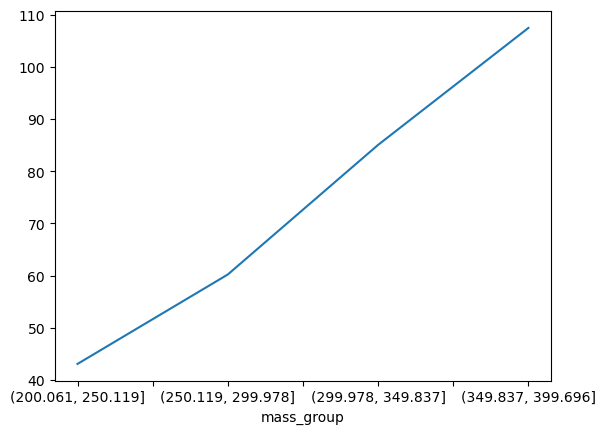

In [32]:
data_200to400.groupby(['mass_group'])['jsc'].mean().plot()

Next, decided to see how much the short circuit current changes in these groups via use of a few different functions (see below).

mass_group
(200.061, 250.119]      7142
(250.119, 299.978]     72137
(299.978, 349.837]    260632
(349.837, 399.696]    556743
Name: jsc, dtype: int64
mass_group
(200.061, 250.119]     477
(250.119, 299.978]     731
(299.978, 349.837]     938
(349.837, 399.696]    1074
Name: jsc, dtype: int64


<Axes: xlabel='mass_group'>

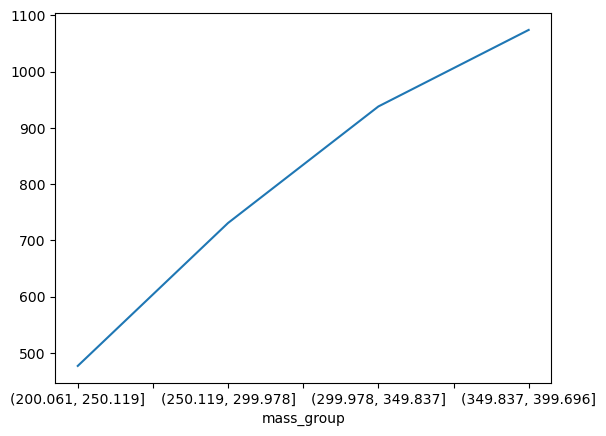

In [33]:
# how many values are in each group?
# .size() was not used in class
print(data_200to400.groupby(['mass_group'])['jsc'].size())

# but how many of the values in each group are actually unique?
# nunique.() was not used in class
print(data_200to400.groupby(['mass_group'])['jsc'].nunique())

# does the same positive linear relationship hold if we just look at the unique values?
# would expect yes and can see this is true
data_200to400.groupby(['mass_group'])['jsc'].nunique().plot()

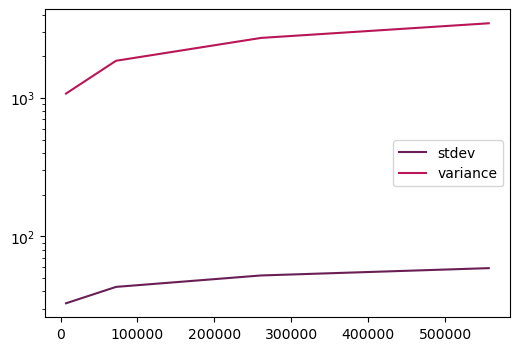

In [34]:
# does the standard deviation of the groups vary positively with group size? would expect yes
number = data_200to400.groupby(['mass_group'])['jsc'].size()
# .std() was not used in class
stdeviation = data_200to400.groupby(['mass_group'])['jsc'].std()

# and what about the variance? does it also scale linearly with group size? expect yes
# .var() was not used in class
variances = data_200to400.groupby(['mass_group'])['jsc'].var()

fig, ax  = plt.subplots(figsize=(6,4))
ax.plot(number, stdeviation, color=colors[2], label='stdev')
ax.plot(number, variances, color=colors[4], label='variance')
ax.set_yscale('log')
plt.legend()
plt.show()

Above, I explored the correlation between mass and short circuit current for this dataset. Additionally, I used a number of groupby functions (.size(), .nunique(), .std(), .var()) to explore how statistics scale with group size. 

**HW 7-4**: Plotting x-y data in Pandas

* Create a single 2x2 composite plot ( _not 4 separate figures_ ) using Sanborn.  The 
plots should contain the following data
    * Upper-left: PCE vs VOC
    * Upper-right: PCE vs JCS
    * Lower-left: $E_{HOMO}$ vs VOC
    * Lower-right: $E_{LUMO}$ vs PCE 
* You should make the plots the highest quality possible and, in your judgment, ready for inclusion in a formal report or publication. You may use a random sample of the full dataset if it's taking to long to plot!
    
* In a Markdown cell, briefly explain the changes you made from the default plot Seaborn and why you made them 

Changes made from the default: 
- Increased the figure size so that the labels weren't overlapping with other plots
- Added a colormap for better visualization
- Manually defined labels for each plot instead of using the default-defined ones
- Defined a custom grid for better visualization
- Made plots with the same x / y variables have the same scales
- Made the style 'ticks'
- Despined irrelevant spines (top and right)
- Used a paper preset context for each subplot

[Controlling figure aesthetics tutorial](https://seaborn.pydata.org/tutorial/aesthetics.html) from seaborn used as guidance for this

In [35]:
sns.set_style('ticks') # set some defaults: also dark, darkgrid, whitegrid, tics
cleandata = data[data['pce']!=0]
data_sample = cleandata.sample(frac=0.01)
ds2 = data_sample.sample(frac=0.05) # let's downsample a bit more for speed purposes.

/var/folders/zl/d_vkwlm12n906ylctdc0f30r0000gn/T/ipykernel_25641/4056905922.py:25: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=ds2['voc'], y=ds2['e_homo_alpha'], ax=axs[1,0], cmap=cmap)


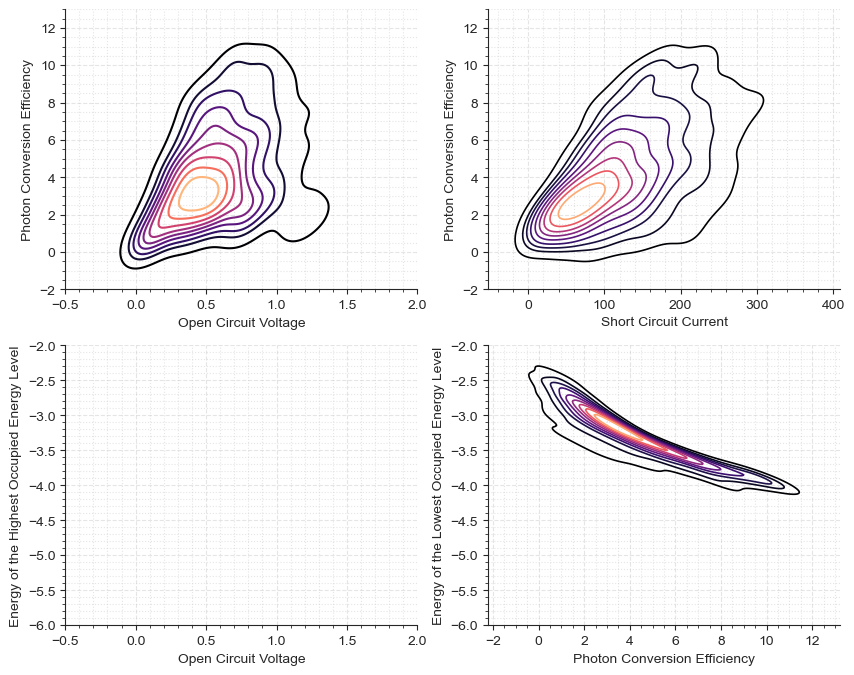

In [36]:
fig, axs = plt.subplots(2,2, figsize=(10,8))
cmap = sns.color_palette("magma", as_cmap=True)

sns.kdeplot(x=ds2['voc'], y=ds2['pce'], ax=axs[0,0], cmap=cmap)
sns.despine()
sns.set_context("paper")
axs[0,0].set_xlabel('Open Circuit Voltage')
axs[0,0].set_xlim(-0.5,2.0)
axs[0,0].set_ylabel('Photon Conversion Efficiency')
axs[0,0].set_ylim(-2,13)
axs[0,0].grid(True, linestyle='--', alpha=0.5)  
axs[0,0].minorticks_on()
axs[0,0].grid(which='minor', linestyle=':', alpha=0.5)

sns.kdeplot(x=ds2['jsc'], y=ds2['pce'], ax=axs[0,1], cmap=cmap)
sns.despine()
sns.set_context("paper")
axs[0,1].set_xlabel('Short Circuit Current')
axs[0,1].set_ylabel('Photon Conversion Efficiency')
axs[0,1].set_ylim(-2,13)
axs[0,1].grid(True, linestyle='--', alpha=0.5)  
axs[0,1].minorticks_on()
axs[0,1].grid(which='minor', linestyle=':', alpha=0.5)

sns.kdeplot(x=ds2['voc'], y=ds2['e_homo_alpha'], ax=axs[1,0], cmap=cmap)
sns.despine()
sns.set_context("paper")
axs[1,0].set_xlabel('Open Circuit Voltage')
axs[1,0].set_xlim(-0.5,2.0)
axs[1,0].set_ylabel('Energy of the Highest Occupied Energy Level')
axs[1,0].set_ylim(-6,-2)
axs[1,0].grid(True, linestyle='--', alpha=0.5)  
axs[1,0].minorticks_on()
axs[1,0].grid(which='minor', linestyle=':', alpha=0.5)

sns.kdeplot(x=ds2['pce'], y=ds2['e_lumo_alpha'], ax=axs[1,1], cmap=cmap)
sns.despine()
sns.set_context("paper")
axs[1,1].set_xlabel('Photon Conversion Efficiency')
axs[1,1].set_ylabel('Energy of the Lowest Occupied Energy Level')
axs[1,1].set_ylim(-6,-2)
axs[1,1].grid(True, linestyle='--', alpha=0.5)  
axs[1,1].minorticks_on()
axs[1,1].grid(which='minor', linestyle=':', alpha=0.5)

**HW 7-5**: Timeseries data in Pandas.  

Load the dataset `stockholm_daily_temp_obs_1859_2012.csv`from HW4 into a pandas dataframe.  Replace the columns giving the day/month/year with a date-time index (look at the documentation for panda datatypes designed for dates and times for ideas).  Explore how to create a good looking plot, using `pandas` plotting functionality, with y-labels that are dates. 

- Can use pandas.to_datetime ([documentation](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html)) to convert day/month/year columns with a date-time index. 

In [37]:
filename = r'stockholm_daily_temp_obs_1859_2012.csv'
df = pd.read_csv(filename, delimiter=',') # I think by default pd.read_csv uses delimiter=',' so it wouldn't be necessary to specify this

In [38]:
df.head()

,#year,month,date,tmorn,tnoon,teven,tmax,tmin
0,1859,1,1,-1.8,0.9,1.8,2.1,-8.1
1,1859,1,2,2.0,1.8,-1.5,2.9,-2.0
2,1859,1,3,4.0,-0.1,4.0,4.0,-6.1
3,1859,1,4,1.5,0.5,-2.9,4.6,-3.2
4,1859,1,5,-1.0,0.5,-0.9,2.0,-5.4


In [39]:
### extract tnoon data between for the years 1950-1952
tnoon_data = df.loc[(df['#year'] >= 1950) & (df['#year'] <= 1952), ['#year', 'month', 'date', 'tnoon', 'tmin', 'tmax']]
tnoon_data.head()

,#year,month,date,tnoon,tmin,tmax
33237,1950,1,1,-1.0,-5.5,-0.2
33238,1950,1,2,1.4,-0.2,1.5
33239,1950,1,3,-3.4,-4.5,1.2
33240,1950,1,4,-11.5,-12.5,-4.3
33241,1950,1,5,-15.2,-16.8,-11.0


In [40]:
# rename columns so the dataframe can be passed to pd.to_datetime
tnoon_data.rename(columns={'#year': 'year'}, inplace=True)
tnoon_data.rename(columns={'date': 'day'}, inplace=True)

tnoon_data.head()

,year,month,day,tnoon,tmin,tmax
33237,1950,1,1,-1.0,-5.5,-0.2
33238,1950,1,2,1.4,-0.2,1.5
33239,1950,1,3,-3.4,-4.5,1.2
33240,1950,1,4,-11.5,-12.5,-4.3
33241,1950,1,5,-15.2,-16.8,-11.0


In [41]:
tnoon_data['date-time'] = pd.to_datetime(tnoon_data[['year', 'month', 'day']])
tnoon_data.set_index('date-time', inplace=True)

In [42]:
tnoon_data.head()

,year,month,day,tnoon,tmin,tmax
date-time,,,,,,
1950-01-01,1950,1,1,-1.0,-5.5,-0.2
1950-01-02,1950,1,2,1.4,-0.2,1.5
1950-01-03,1950,1,3,-3.4,-4.5,1.2
1950-01-04,1950,1,4,-11.5,-12.5,-4.3
1950-01-05,1950,1,5,-15.2,-16.8,-11.0


[pandas.DataFrame.plot documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.html)

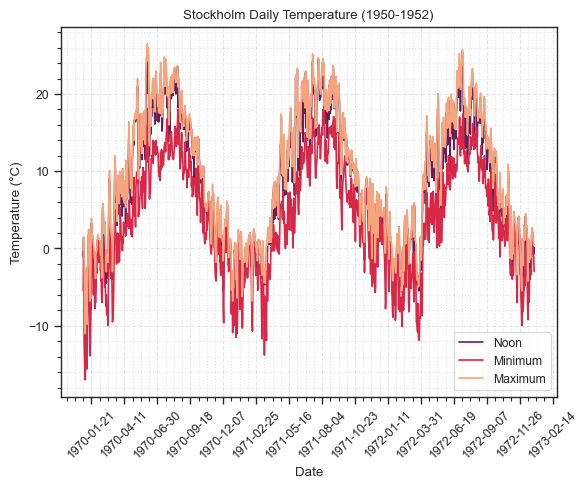

In [43]:
ax = tnoon_data.plot(y='tnoon', color=colors[2], label='Noon', legend=1, use_index=0)
tnoon_data.plot(y='tmin', color=colors[5], label='Minimum', legend=1, use_index=0, ax=ax)
tnoon_data.plot(y='tmax', color=colors[8], label='Maximum', legend=1, use_index=0, ax=ax)

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Stockholm Daily Temperature (1950-1952)')

# Used ChatGPT to identify the mdates function and how to call it to make the x-axis labels be the date-time dates
import matplotlib.dates as mdates
ax.set_xticklabels([])  # Remove the x-axis tick labels
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=80))  # Adjust the interval as needed
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.xticks(rotation=45)

ax.grid(True, linestyle='--', alpha=0.5)  
ax.minorticks_on()
ax.grid(which='minor', linestyle=':', alpha=0.5)

plt.show()